In [145]:
%load_ext cypher

The cypher extension is already loaded. To reload it, use:
  %reload_ext cypher


In [146]:
%%cypher
MATCH (n)
OPTIONAL MATCH (n)-[r]-()
DELETE n,r

14 relationship deleted.
8 nodes deleted.


[]

In [147]:
%cypher CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE

0 rows affected.


[]

In [148]:
%cypher CREATE CONSTRAINT ON (u:User) ASSERT u.username IS UNIQUE

0 rows affected.


[]

In [149]:
%cypher CREATE CONSTRAINT ON (h:HashTag) ASSERT h.hashtag IS UNIQUE

0 rows affected.


[]

![png](./images/Model.png)

In [150]:
from pprintpp import pprint as pp


In [151]:
from py2neo import Graph, Relationship
import json

graph = Graph()

In [152]:
def add_property(obj, json, name):
    if name in json:
        obj[name] = json[name]

In [153]:
def parse_user(user_json):
    user = graph.merge_one("User", "username", user_json['screen_name'])
    
    add_property(user, user_json, 'created_at')
    add_property(user, user_json, 'description')
    add_property(user, user_json, 'favourites_count')
    add_property(user, user_json, 'followers_count')
    add_property(user, user_json, 'friends_count')
    add_property(user, user_json, 'statuses_count')
    add_property(user, user_json, 'time_zone')
    add_property(user, user_json, 'name')
    add_property(user, user_json, 'profile_image_url')
    
    user.push()
    return user

In [154]:
def parse_tweet(tweet_json):
    user = parse_user(tweet_json['user'])
    
    tweet = graph.merge_one("Tweet", "id", tweet_json['id'])
    add_property(tweet, tweet_json, 'created_at')
    add_property(tweet, tweet_json, 'lang')
    add_property(tweet, tweet_json, 'retweet_count')
    add_property(tweet, tweet_json, 'source')
    add_property(tweet, tweet_json, 'text')
    
    tweet.push()
    
    user_tweeted_tweet = Relationship(user, "TWEETED", tweet)
    graph.create_unique(user_tweeted_tweet)
    
    if 'user_mentions' in tweet_json:
        for user_mention_json in tweet_json['user_mentions']:
            user_mencioned = parse_user(user_mention_json)
            tweet_mencioned_user = Relationship(tweet, "MENCIONED", user_mencioned)
            graph.create_unique(tweet_mencioned_user)
 
    if 'entities' in tweet_json:
        for entity in tweet_json['entities']:
            hashtag = graph.merge_one("HashTag", "hashtag", entity)
            tweet_HashTag_hashtag = Relationship(tweet, "HASHTAG", hashtag)
            graph.create_unique(tweet_HashTag_hashtag)

    if 'retweeted_status' in tweet_json:
        user_retweeted = parse_user(tweet_json['retweeted_status']['user'])
        tweet_retweetOf_user = Relationship(tweet, "RETWEET_OF", user_retweeted)
        graph.create_unique(tweet_retweetOf_user)
        
        parse_tweet(tweet_json['retweeted_status'])

In [155]:
def load_file(tweets_data_path):
    tweets_file = open(tweets_data_path, "r")
    for tweet in tweets_file:
        parse_tweet(json.loads(tweet))

In [156]:
load_file('../data/tweets.json')

In [170]:
%%cypher
MATCH p = ((u:User {username : 'couchbase'})-[r:TWEETED]->t)
RETURN u.username, t.text, type(r)
LIMIT 10

10 rows affected.


u.username,t.text,type(r)
couchbase,Marriott leads hotel industry transformation: re-platforming legacy systems with #NoSQL. https://t.co/7NP6vmovb3 via @diginomica @jonerp,TWEETED
couchbase,The 3 mega-trends that define businesses leading the digital economy by #Couchbase CEO @bobwiederhold: https://t.co/pbLjou71nG #NoSQL,TWEETED
couchbase,One of #NoSQL world’s more venerable products delivers its 4.0 release via @andrewbrust @ZDNET https://t.co/lZ1Q64vdPU,TWEETED
couchbase,Get rapid ramp-up on #NoSQL application development with lessons and labs. Try free online training today! https://t.co/Y6KSzbrrl3,TWEETED
couchbase,Get rapid ramp-up on #NoSQL application development with lessons and labs. Try free today! http://t.co/Y6KSzbJ2cB http://t.co/agmqeTd3jz,TWEETED
couchbase,Want to quickly learn to build #NoSQL applications? Get FREE online training today: https://t.co/pPYZvZdqDi https://t.co/9DFR3yTTfL,TWEETED
couchbase,RT @arungupta: Blogged: Why Couchbase over MongoDB? #SayNoToMongoDB: MongoDB is one of the most popular NoSQL databases. Its ... https://t.…,TWEETED
couchbase,Top 5 reasons to secure #NoSQL deployments. Protect data using #Vormetric's Data Security platform for #Couchbase: https://t.co/tDnyyUzayz,TWEETED
couchbase,"Download #Couchbase 4.0 and build apps using #SQL for #JSON. Fast, efficient, powerful query http://t.co/Xt8cpz7Ffk #database #developers",TWEETED
couchbase,#CBLiveNY presentations &amp; videos are now posted. Learn about the latest innovations in 4.0 &amp; #N1QL. Watch now: https://t.co/1lXyLtUbNV,TWEETED


In [176]:
%%cypher match (n:HashTag)-[r]-() 
return n.hashtag, count(r) as degree 
order by degree desc
limit 10

10 rows affected.


n.hashtag,degree
NoSQL,1031
MongoDB,475
BigData,471
nosql,439
Java,404
Hadoop,360
hive,309
SoapUi,309
bigdata,117
noSQL,87


In [177]:
%matplotlib inline

In [186]:
results = %%cypher match (n:HashTag)-[r]-()  return n.hashtag as HashTag, count(r) as Degree order by Degree desc limit 10

10 rows affected.


In [187]:
results.get_dataframe()

,HashTag,Degree
0,NoSQL,1031
1,MongoDB,475
2,BigData,471
3,nosql,439
4,Java,404
5,Hadoop,360
6,hive,309
7,SoapUi,309
8,bigdata,117
9,noSQL,87


([<matplotlib.patches.Wedge at 0x7f39e9d1c4d0>,
  <matplotlib.text.Text at 0x7f39e9d3a210>])

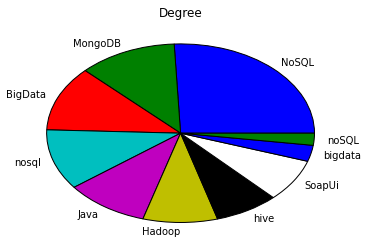

In [188]:
results.pie()

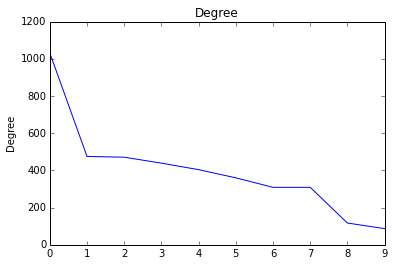

In [189]:
results.plot()

<Container object of 10 artists>

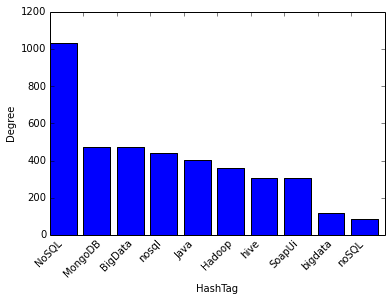

In [190]:
results.bar()

10 rows affected.


(<networkx.classes.multidigraph.MultiDiGraph at 0x7f39ea186b10>,
 <matplotlib.collections.PathCollection at 0x7f39e9c733d0>)

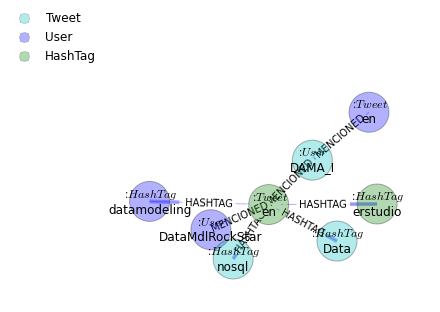

In [191]:
results = %cypher match (n)-[r]-() return n, r limit 10
results.draw()

In [ ]:
query = """
    MATCH (h:Hashtag)<-[:HASHTAG]-(:Tweet)-[:HASHTAG]->(:Hashtag {hashtag:{hashtag}}) 
    WHERE h.hashtag <> {hashtag}
    RETURN h.hashtag AS hashtag, COUNT(*) AS count
    ORDER BY count DESC
    LIMIT 10
"""

hashtag_count = cypher(graph, query, hashtag = "#neo4j")



In [201]:
from py2neo import Graph

graph = Graph()
cypher = graph.cypher
results = cypher.execute(
"""
MATCH (u:User)
WHERE exists(u.followers_count)
return distinct u.username, u.followers_count
order by u.followers_count DESC LIMIT 10
""")


In [211]:
type(results)

py2neo.cypher.core.RecordList

In [200]:
%%cypher
MATCH (u:User)
WHERE exists(u.followers_count)
return distinct u.username, u.followers_count
order by u.followers_count DESC LIMIT 10

10 rows affected.


u.username,u.followers_count
socialmedia2day,496434
googlecloud,447433
Azure,383514
DavidPapp,215119
couchbase,160196
iamdevloper,125378
docker,90833
javacodegeeks,79215
developerWorks,75487
Adel__Almalki,74156


In [197]:
%%cypher
match n
return distinct labels(n)

3 rows affected.


labels(n)
[u'User']
[u'Tweet']
[u'HashTag']
